# Linear Regression with multiple variables

***

The goal of multiple Linear regression is to find a linear relation between a dependant variable $y$ 
and multiple independent variables $X$, assuming that such a relation exists

The process is the same as [simple linear regression](./SimpleLinearRegression.ipynb), having multiple independent variables instead of one

***

## Covered in this notebook
* Check for some linear relation in an unknown dataset
* Manipulate a simple dataset with pandas
* Implement Label encoding
* Implement Normalization via standardization
* Implement Scikitlearn and a "by hand" with gradient descent multiple linear regression
* Give some senses of how linear regression can react with different datasets

## Not covered in this notebook
* Verification of all the [linear regression assumptions](https://www.statisticssolutions.com/wp-content/uploads/wp-post-to-pdf-enhanced-cache/1/assumptions-of-multiple-linear-regression.pdf)
* Data analysis
* Model fit advanced analysis

***


## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as sk_linear_models

## The dataset

The dataset comes from https://www.kaggle.com/karthickveerakumar/startup-logistic-regression

It represents the profit made by 50 startups according to R&D, administration and marketing expenses, as of their state of location in the US.

Let's try to see if one can reasonably predict the profit of a startup according to these stats

In [2]:
raw_data = pd.read_csv('datasets/Kaggle50StartupsMultipleLinearRegression.csv', delimiter=',')

raw_data.head()

R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94

### Label encoding

The state columns is a list of States, linear regression only works on numerical data

Let's use some [categorical encoding](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/) to allow us to use this data in our model

A good encoding solution for the state column is *label encoding*: each state is replaced by a corresponding number

In [3]:
data = raw_data.copy()

# Label encoding of the state column
data.State = raw_data.State.astype('category')
states = data.State.cat.categories
data.State = data.State.cat.codes

print(f'possible states {", ".join(states)}')
data.head()

possible states California, Florida, New York


R&D Spend  Administration  Marketing Spend  State     Profit
0  165349.20       136897.80        471784.10      2  192261.83
1  162597.70       151377.59        443898.53      0  191792.06
2  153441.51       101145.55        407934.54      1  191050.39
3  144372.41       118671.85        383199.62      2  182901.99
4  142107.34        91391.77        366168.42      1  166187.94

## Looking at the data

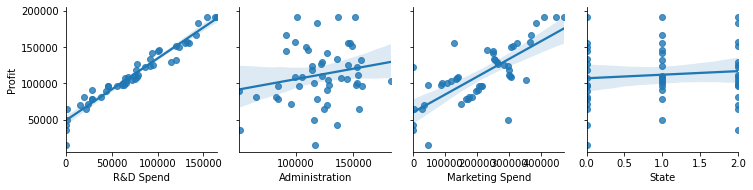

In [4]:
sns.pairplot(data=data,
             y_vars=['Profit'],
             x_vars=[d for d in data.columns if d != 'Profit'],
             kind='reg');

It looks like R&D and Marketing spend have some linear relationship with the profit, but Administration and State a bit less.

Let's look how linear regression will perform on this dataset

First let's extract the data as feature and labels, $X$ and $y$

In [5]:
# Utility function to extract features and labels according to column names with default to all columns
# This is useful to test the model with specific features
def extract_X_y(data, y_column, x_columns=None):
    if x_columns is None:
        x_columns = [d for d in data.columns if d != y_column]

    X = data[x_columns]
    y = data[y_column].to_numpy().reshape(-1, 1)
    return X, y

X, y = extract_X_y(data, y_column='Profit')

X.shape, y.shape

((50, 4), (50, 1))

<a id='feature_scaling'></a>

### Data normalization

The notion of multiple features with gradient descent brings in the problem of [feature scaling](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/). During the descent a feature with and higher value range will have more impact that one with a smaller range

In the present case, it is not the linear regression itself [but the method we use to do it by hand](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data) that require data normalization

For convenience and to better compare the results, let's normalize the data before using it with any regression implementation, even if sklearn implementation would not really require it

The method used here is called standardization. For short we rescale the data to have a mean value of 0 and a standard deviation of 1

In [6]:
# Utility class that stores a dataset mean and variance to allow
# later standardization of other data like predict or unknown examples
class Standardizer():
    def __init__(self, X):
        self.mean = X.mean()
        self.std = X.std()

    def standardize(self, X):
        return  (X - self.mean) / self.std

norm = Standardizer(X)
X = norm.standardize(X)

## Implementations

### The Scikitlearn version

In [7]:
reg = sk_linear_models.LinearRegression().fit(X, y)
sklearn_result = np.append(reg.coef_[0], reg.intercept_[0])

### The by hand version

See [simple linear regression](./SimpleLinearRegression.ipynb) for a better understanding

In [8]:
def multiple_linear_gradient_descent(X, y, alpha=0.01, n=500):
    X['Bias'] = 1                           # adding a bias column for matrix operations
    thetas = np.zeros((X.shape[1], 1))      # hypothesis is txbias + t1x1 + t2x2 + t3x3 + ... 
    m = len(X)

    costs = np.zeros(n)                     
    for i in range(n):
        # updating all thetas simultaneously
        thetas = thetas - alpha * X.transpose().dot(X.dot(thetas) - y) / m
        # storing the cost at each iteration to inspect how the learning performed
        costs[i] = 0.5 * (np.square(X.dot(thetas) - y)).sum() / m
    del X['Bias']
    return thetas, costs

thetas, costs = multiple_linear_gradient_descent(X, y, alpha=0.1)
thetas = thetas.rename(columns={0: 'Manual Gradient Descent'})

#### Check that the gradient descent performed well

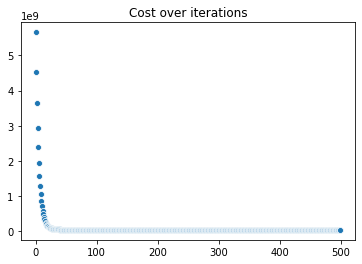

In [9]:
sns.scatterplot(data=costs).set(title='Cost over iterations');

### Comparing the results

In [10]:
thetas['Sklearn Fit'] = sklearn_result
theta_all = thetas
theta_all

Manual Gradient Descent    Sklearn Fit
R&D Spend                   36985.953855   36986.187309
Administration               -751.519412    -751.601425
Marketing Spend              3329.901108    3329.680128
State                         -18.584745     -18.592887
Bias                       112012.639200  112012.639200

It looks like our handy gradient descent implementation performed as good as the sklearn implementation, even if much slower

### Prediction vs real value for one example

In [11]:
Xp, yp = extract_X_y(data[:1], y_column='Profit')
Xp = norm.standardize(Xp)
Xp['Bias'] = 1

# using the manual fit to predict a value
th = theta_all['Manual Gradient Descent'].to_numpy().reshape(-1, 1)
predict = Xp.dot(th)
print(f"Prediction: {predict[0][0]:.3f}, real value {yp[0][0]:.3f}")

Prediction: 192502.825, real value 192261.830


At this point, it looks that we found some linear relation between the profit of a startup and its parameters,

Let's go a little bit deeper to have a sense of what we have or have not found

##  Evaluating our linear regression model with a test and train set

In this part, the model is used to predict values never met, this is a way of measuring how well the algorithm performed

In [12]:
# Split the dataset
train = data.sample(frac=0.8, random_state=200)
test = data.drop(train.index)

def evaluate_model(train, test, x_columns=None):
    # train the model
    Xtrain, y_train = extract_X_y(train, y_column='Profit', x_columns=x_columns)
    nrm_train = Standardizer(Xtrain)
    Xtrain = nrm_train.standardize(Xtrain)
    thetas_train, _ = multiple_linear_gradient_descent(Xtrain, y_train)
    
    # predict on the test set
    Xtest, ytest = extract_X_y(test, y_column='Profit', x_columns=x_columns)
    Xtest = nrm_train.standardize(Xtest)
    Xtest['Bias'] = 1
    predicts = Xtest.dot(thetas_train)
    del Xtest['Bias']
    
    # Comparing the results with the real values
    mean_square_error = np.square(predicts - ytest)
    result = pd.DataFrame(Xtest)
    result['Profit'] = ytest
    result['Predicts'] = predicts
    result['Error'] = np.sqrt(mean_square_error)
    pd.options.display.float_format = "{:,.2f}".format
    print(thetas_train)
    print(f"This model gives an average error of {result['Error'].mean():.2f}")
    return result

evaluate_model(train, test)

                         0
R&D Spend        33,480.76
Administration    1,495.70
Marketing Spend   9,191.33
State             1,458.07
Bias            110,168.91
This model gives an average error of 9166.08


R&D Spend  Administration  Marketing Spend  State     Profit   Predicts  \
4        1.47           -1.02             1.24  -0.03 166,187.94 169,049.32   
12       0.46            0.20             0.34  -0.03 141,585.52 128,954.71   
14       1.00            1.20             0.39  -0.03 132,602.65 149,145.57   
15       0.89            0.04             0.43   1.13 129,917.04 145,687.56   
16       0.13            0.01             0.45  -1.19 126,992.93 116,917.37   
25      -0.15            0.62            -0.52  -1.19 107,404.34  99,582.00   
26       0.07            0.78            -0.55  -0.03 105,733.54 108,684.42   
27       0.01            0.22             1.14   1.13 105,008.31 122,766.33   
41      -0.92           -1.25            -0.31  -0.03  77,798.83  74,644.32   
42      -1.01           -0.86            -0.44  -1.19  71,498.49  69,404.67   

       Error  
4   2,861.38  
12 12,630.81  
14 16,542.92  
15 15,770.52  
16 10,075.56  
25  7,822.34  
26  2,950.88  
27 17,758.02  
41  3,154.51  
42  2,093.82

So we have a model that can relatively predict the income of a startup, let's see if it is possible to do better

### Remove columns that seemed not linear

When looking at the dataset, the Administration and State columns look like they have a poor linear relation with the profit

Let's see what's going on without them

In [13]:
# Only keeping R&D Spend and Marketing Spend columns
evaluate_model(train, test, x_columns=['R&D Spend', 'Marketing Spend'])

                         0
R&D Spend        34,537.29
Marketing Spend   8,427.80
Bias            110,168.91
This model gives an average error of 8268.03


R&D Spend  Marketing Spend     Profit   Predicts     Error
4        1.47             1.24 166,187.94 171,230.24  5,042.30
12       0.46             0.34 141,585.52 128,918.31 12,667.21
14       1.00             0.39 132,602.65 148,151.91 15,549.26
15       0.89             0.43 129,917.04 144,585.49 14,668.45
16       0.13             0.45 126,992.93 118,430.30  8,562.63
25      -0.15            -0.52 107,404.34 100,624.45  6,779.89
26       0.07            -0.55 105,733.54 108,059.27  2,325.73
27       0.01             1.14 105,008.31 119,924.53 14,916.22
41      -0.92            -0.31  77,798.83  75,830.74  1,968.09
42      -1.01            -0.44  71,498.49  71,699.04    200.55

The model performed slightly better, this is not a proof but gives some sense of how multiple linear regression reacts with different datasets

# Conclusion

Looking at an unknown dataset, we saw that a linear relation could possibly be found between the variables

Then after some simple data transformation, we implemented a by hand multiple linear regression using gradient descent

Our implementation performed as well as the scikitlearn implementation and gave us a some way of predicting the profit of a startup
 
We saw that a better selection of the data have an impact of how well a model can perform

This notebook was inspired among others by [this one](https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/) that goes deeper in explanations and concepts that one can encounter in a real world multiple linear regression

# What's next

How to classify data using [Logistic Regression](./LogisticRegression.ipynb)

